In [1]:
#Loads the MiniImageNet and EuroSAT training data. If yours are not stored in Google Drive, you can disregard this.
from google.colab import drive

drive.mount('/content/drive/')
!tar xvf "/content/drive/MyDrive/train1.tar"
!unzip "/content/drive/MyDrive/EuroSAT_RGB.zip"


Streaming output truncated to the last 5000 lines.
  inflating: EuroSAT_RGB/Residential/Residential_489.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_1573.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_270.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_516.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2683.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_502.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2697.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_264.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2867.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2873.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_258.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2126.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_1349.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2640.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2898.jpg  
  inflating: EuroSAT_RGB/Residential/Residential_2654.j

In [2]:
#Creates DataLoaders for MiniImageNet data
#If you are not using Google Drive, fix the file paths for the ImageFolders
import torch
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import v2



augmentData = False #change this to not use data augmentation
augmentCount = 10


#Transforms images to the required format for ResNet
my_transform = v2.Compose([v2.Resize(224),
                    v2.ToTensor(),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    v2.ToDtype(torch.float32)])

#Does the same as above, but applies random data augmentations
augment = v2.Compose([v2.Resize(224),
                       v2.RandomHorizontalFlip(p=0.5),
                       v2.RandomVerticalFlip(p=0.5),
                       v2.ColorJitter(brightness=(0.25,0.75),contrast=(0.25,0.75),saturation=(0.25,0.75)),
                       v2.ToTensor(),
                       v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                       v2.ToDtype(torch.float32)])

full_data = None
ds_lists = []
#10 lists of randomly augmented data
if augmentData:
  for i in range(augmentCount):
    ds_lists  += [ImageFolder("/content/train/",transform=augment)]
  full_data = torch.utils.data.ConcatDataset(ds_lists)

else:
  full_data = ImageFolder("/content/train/",transform=my_transform)

#Train/test/validation split
training_data, val_data, test_data = torch.utils.data.random_split(full_data, [0.6,0.2,0.2])

#Create data loaders
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data,batch_size=64, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:

resnet_18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet_18.fc = torch.nn.Linear(in_features=512, out_features=64, bias=True) #adjust ResNet's final layer to the number of labels we have
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_18.parameters(),lr=0.01,momentum=0.9)
use_cuda = torch.cuda.is_available()
if use_cuda:
    resnet_18 = resnet_18.cuda()

train_accs = []
val_accs = []
loss_calcs = []
#Train on MiniImageNet data
for epoch in range(10):
  correct = 0.0
  num_images = 0.0
  for i_batch, (images, labels) in enumerate(train_loader):
      if use_cuda:
          images = images.cuda()
          labels = labels.cuda()
      output = resnet_18.forward(images)
      loss = loss_function(output.squeeze(),labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #training accuracy
      num_images += len(images)
      preds = output.argmax(dim=1)
      correct += preds.eq(labels).sum()

  #get end-of-epoch validation accuracy
  val_correct = 0.0
  val_num_images = 0.0
  for i_batch, (images, labels) in enumerate(val_loader):
      if use_cuda:
          images = images.cuda()
          labels = labels.cuda()
      outs = resnet_18.forward(images)
      val_num_images += len(images)
      preds = outs.argmax(dim=1)
      val_correct += preds.eq(labels).sum()


  print("Epoch %i, accuracy %f, loss %f, valid accuracy %f"%(epoch,correct/num_images,loss.item(),val_correct/val_num_images))
  train_accs += [correct/num_images]
  val_accs += [val_correct/val_num_images]
  loss_calcs += [loss.item()]


#test accuracy after training
test_correct = 0.0
test_num_images = 0.0
for i_batch, (images, labels) in enumerate(test_loader):
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
    outs = resnet_18.forward(images)
    test_num_images += len(images)
    preds = outs.argmax(dim=1)
    test_correct += preds.eq(labels).sum()
print("Test accuracy after 10 epochs: %f"%(test_correct/test_num_images))

torch.save(resnet_18,f="/content/drive/MyDrive/resnet_18%s.pt"%("_augmented" if augmentData else ""))


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Epoch 0, accuracy 0.688672, loss 0.764856, valid accuracy 0.766406
Epoch 1, accuracy 0.863802, loss 0.465346, valid accuracy 0.772396
Epoch 2, accuracy 0.941233, loss 0.210544, valid accuracy 0.782292
Epoch 3, accuracy 0.982378, loss 0.102839, valid accuracy 0.814583
Epoch 4, accuracy 0.996267, loss 0.011921, valid accuracy 0.827604
Epoch 5, accuracy 0.999609, loss 0.007744, valid accuracy 0.835026
Epoch 6, accuracy 1.000000, loss 0.002989, valid accuracy 0.842839
Epoch 7, accuracy 1.000000, loss 0.000956, valid accuracy 0.843229
Epoch 8, accuracy 1.000000, loss 0.001203, valid accuracy 0.841406
Epoch 9, accuracy 1.000000, loss 0.000756, valid accuracy 0.843880
Test accuracy after 10 epochs: 0.839714


In [ ]:
#Preprocessing for transfer learning stage
from random import sample
from torch.utils.data import Subset
import torch
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import v2

full_eurosat = ImageFolder("/content/EuroSAT_RGB/",transform=my_transform)


#create training and testing loaders for EuroSAT data
def get_eurosat_loaders():

  #get five random categories
  five_choices = sample(list(full_eurosat.class_to_idx.items()),k=5)
  #needed to ensure that labels range from 0 to n-1, where n is number of classes
  cmap = {j[1]:i for i,j in enumerate(five_choices)}

  #drop categories that aren't part of experiment
  idx = []
  for f in list(map(lambda a:a[1],five_choices)):
    idx += []
    idx += [[i for i in range(len(full_eurosat)) if full_eurosat.imgs[i][1]==f]]

  #sample 20 indices from each category
  idx_ = list(map(lambda a:sample(a,k=20),idx))
  idx_test = [sample(i,k=5) for i in idx_]

  idx_train_flatten = [i for j in idx_ for i in j]
  idx_test_flatten = [i for j in idx_test for i in j]

  #create loaders
  eurosat_subset_train = Subset(full_eurosat,idx_train_flatten)
  eurosat_subset_test = Subset(full_eurosat,idx_test_flatten)

  eurosat_train_loader = DataLoader(eurosat_subset_train, batch_size=4, shuffle=True)
  eurosat_test_loader = DataLoader(eurosat_subset_test,batch_size=4,shuffle=True)
  return eurosat_train_loader, eurosat_test_loader, cmap


In [ ]:
#Train the transfer learning
import datetime
loss_function = torch.nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

mode = 2

eurosat_train_accs = []
eurosat_test_accs = []
print(datetime.datetime.now())
for i in range(10):
  resnet_18_reloaded = None
  if mode == 0: #baseline
      resnet_18_reloaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
  if mode == 1: #not augmented
      resnet_18_reloaded = torch.load("/content/drive/MyDrive/resnet_18.pt")
  if mode == 2: #augmented
      resnet_18_reloaded = torch.load("/content/drive/MyDrive/resnet_18_augmented.pt")

  if mode: #freeze gradients unless we are doing the baseline (training ResNet directly on EuroSAT)
    for p in resnet_18_reloaded.parameters():
      p.requires_grad = False
  #adjust output layer to match number of classes
  resnet_18_reloaded.fc = torch.nn.Linear(in_features=512, out_features=5, bias=True)
  if use_cuda:
    resnet_18_reloaded = resnet_18_reloaded.cuda()

  optimizer = torch.optim.SGD(resnet_18_reloaded.parameters(),lr=0.01,momentum=0.9)
  eurosat_train_loader, eurosat_test_loader, cmap = get_eurosat_loaders()
  #fine tuning is faster than the pre-training stage so we can do more epochs
  for epoch in range(100):
    correct = 0.0
    num_images = 0.0

    for i_batch, (images, labels) in enumerate(eurosat_train_loader):
        #adjust labels to range required by PyTorch
        labels = torch.Tensor([cmap[i.item()] for i in labels]).long()

        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        output = resnet_18_reloaded.forward(images)
        loss = loss_function(output.squeeze(),labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        num_images += len(images)
        preds = output.argmax(dim=1)
        correct += preds.eq(labels).sum()
    eurosat_test_correct = 0.0
    eurosat_test_images = 0.0
    #accuracy calcs for test set
    for i_batch, (images, labels) in enumerate(eurosat_test_loader):
        labels = torch.Tensor([cmap[i.item()] for i in labels]).long()
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        outs = resnet_18_reloaded.forward(images)
        eurosat_test_images += len(images)
        preds = outs.argmax(dim=1)
        eurosat_test_correct += preds.eq(labels).sum()
    if epoch==99:
      print("Epoch %i, eurosat train accuracy %f, loss %f, Eurosat test accuracy %f"%(epoch,correct/num_images,loss.item(),eurosat_test_correct/eurosat_test_images),datetime.datetime.now())
      eurosat_train_accs += [correct/num_images]
      eurosat_test_accs += [eurosat_test_correct/eurosat_test_images]


2024-01-02 00:11:29.304597
Epoch 99, eurosat train accuracy 0.890000, loss 0.000000, Eurosat test accuracy 0.920000 2024-01-02 00:12:08.601217
Epoch 99, eurosat train accuracy 0.950000, loss 1.917777, Eurosat test accuracy 0.880000 2024-01-02 00:12:49.054105
Epoch 99, eurosat train accuracy 0.870000, loss 0.000000, Eurosat test accuracy 0.720000 2024-01-02 00:13:27.215512
Epoch 99, eurosat train accuracy 0.900000, loss 0.000003, Eurosat test accuracy 0.960000 2024-01-02 00:14:04.866387
Epoch 99, eurosat train accuracy 0.830000, loss 0.000000, Eurosat test accuracy 0.760000 2024-01-02 00:14:43.517224
Epoch 99, eurosat train accuracy 0.860000, loss 0.003735, Eurosat test accuracy 0.920000 2024-01-02 00:15:20.541887
Epoch 99, eurosat train accuracy 0.930000, loss 0.000000, Eurosat test accuracy 0.840000 2024-01-02 00:15:59.680720
Epoch 99, eurosat train accuracy 0.920000, loss 7.294376, Eurosat test accuracy 0.920000 2024-01-02 00:16:37.544777
Epoch 99, eurosat train accuracy 0.850000, lo

Eurosat train accuracy (average) tensor(0.8380, device='cuda:0')
Eurosat test accuracy (average) tensor(0.7960, device='cuda:0')


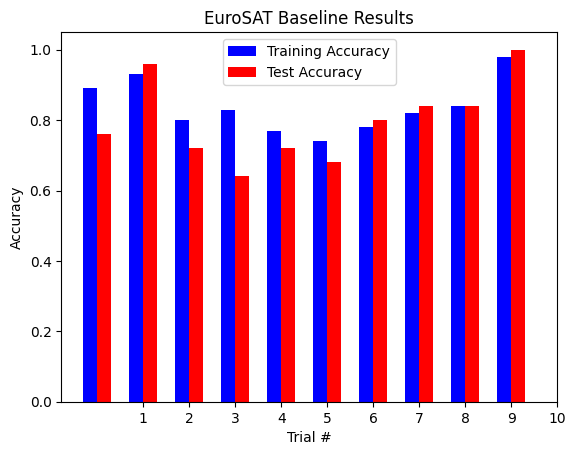

In [ ]:
#Used for generating plots.
import matplotlib.pyplot as plt
import numpy as np
plt.plot([i.item() for i in train_accs],label="Training Accuracy",linewidth=2.5)
plt.plot([i.item() for i in val_accs],label="Validation Accuracy",linewidth=2.5)
plt.legend()
plt.xlabel("Epoch")
ax = plt.subplot(111)
ax.set_xticks(range(1,11))
plt.ylabel("Accuracy")
plt.title("MiniImageNet Training Results")

plt.show()
plt.clf()
plt.plot(loss_calcs,linewidth=2)
plt.xlabel("Epoch")
ax = plt.subplot(111)
ax.set_xticks(range(1,11))
plt.ylabel("Loss")
plt.title("Loss by Epoch")
plt.show()
plt.clf()


runs = np.arange(10)
ax = plt.subplot(111)
ax.bar(runs-0.15,[i.item() for i in eurosat_train_accs],width=0.3,color="b",align="center",label="Training Accuracy")
ax.bar(runs+0.15,[i.item() for i in eurosat_test_accs],width=0.3,color="r",align="center",label="Test Accuracy")
ax.set_xticks(range(1,11))
plt.xlabel("Trial #")
plt.ylabel("Accuracy")
plt.legend()
plt.title("EuroSAT %s Results"%("Transfer Learning" if mode else "Baseline"))


print("Eurosat train accuracy (average)", (sum(eurosat_train_accs)/len(eurosat_train_accs)))
print("Eurosat test accuracy (average)", (sum(eurosat_test_accs)/len(eurosat_test_accs)))